In [102]:
#importing necessary libraries for the project 
import pandas as pd
from scipy import stats
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
import statsmodels.api as sm



### **IMPORTING DATA OF ATGL, ADANIGREEN, ADANIENSOL FROM ALPHAVANTAGE API**

In [96]:
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=ATGL.BSE&outputsize=full&apikey=1X1KKRX3SQO7R688'
r = requests.get(url)
data = r.json()
df = pd.DataFrame(data["Time Series (Daily)"]).T    
df.columns = ["Open", "High", "Low", "Close", "Volume"]
df.index = pd.to_datetime(df.index)
df = df.astype(float)
# Filter data for the last 3 years
three_years_ago = pd.Timestamp.today() - pd.DateOffset(years=3)
df = df[df.index >= three_years_ago]

In [97]:
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=ADANIGREEN.BSE&outputsize=full&apikey=1X1KKRX3SQO7R688'
r = requests.get(url)
data = r.json()
df1 = pd.DataFrame(data["Time Series (Daily)"]).T    
df1.columns = ["Open", "High", "Low", "Close", "Volume"]
df1.index = pd.to_datetime(df1.index)
df1 = df1.astype(float)
# Filter data for the last 3 years
three_years_ago1 = pd.Timestamp.today() - pd.DateOffset(years=3)
df1 = df1[df1.index >= three_years_ago]

In [98]:
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=ADANIENSOL.BSE&outputsize=full&apikey=1X1KKRX3SQO7R688'
r = requests.get(url)
data = r.json()
df2 = pd.DataFrame(data["Time Series (Daily)"]).T    
df2.columns = ["Open", "High", "Low", "Close", "Volume"]
df2.index = pd.to_datetime(df2.index)
df2 = df2.astype(float)
# Filter data for the last 3 years
three_years_ago2 = pd.Timestamp.today() - pd.DateOffset(years=3)
df2 = df2[df2.index >= three_years_ago]

#### MERGING THE DATA

In [99]:
df['Stock'] = 'ATGL'
df1['Stock'] = 'ADANIGREEN'
df2['Stock'] = 'ADANIENSOL'

# Concatenate the DataFrames vertically (along rows)
combined_data = pd.concat([df, df1, df2], ignore_index=False)

# Ensure the index is datetime and sorted
combined_data.index = pd.to_datetime(combined_data.index)
combined_data = combined_data.sort_index()

# Calculate Daily Returns for each stock
combined_data['Daily Returns'] = combined_data.groupby('Stock')['Close'].pct_change()

# Drop any NaN values that result from pct_change
combined_data = combined_data.dropna()

# Verify the structure
print("Combined Data Head:")
print(combined_data.head())

Combined Data Head:
               Open     High      Low    Close   Volume       Stock  \
2022-02-25  1980.05  2052.20  1980.05  2035.05  10101.0  ADANIENSOL   
2022-02-25  1567.75  1621.90  1550.10  1576.70   4349.0        ATGL   
2022-02-25  1875.00  1954.40  1869.95  1922.75  51403.0  ADANIGREEN   
2022-02-28  2016.00  2136.80  1989.20  2136.65  37631.0  ADANIENSOL   
2022-02-28  1520.00  1606.45  1517.00  1587.35   9875.0        ATGL   

            Daily Returns  
2022-02-25       0.039378  
2022-02-25       0.012913  
2022-02-25       0.038651  
2022-02-28       0.049925  
2022-02-28       0.006755  


### **PERFORMING ONE-WAY ANOVA**

In [100]:
from scipy.stats import f_oneway

# Group the daily returns by stock
groups = [combined_data[combined_data['Stock'] == stock]['Daily Returns'].values 
          for stock in combined_data['Stock'].unique()]

# Perform one-way ANOVA
f_statistic, p_value = f_oneway(*groups)

# Print the results
print("\nOne-Way ANOVA Results for Daily Returns Across Stocks:")
print(f"F-Statistic: {f_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print("There is a statistically significant difference in the means of Daily Returns across the stocks.")
    print("This suggests that at least one stock's daily returns differ significantly from the others.")
else:
    print("There is no statistically significant difference in the means of Daily Returns across the stocks.")


One-Way ANOVA Results for Daily Returns Across Stocks:
F-Statistic: 0.0276
P-value: 0.9728
There is no statistically significant difference in the means of Daily Returns across the stocks.


### **Interpretation of One-Way ANOVA Results**

The One-Way ANOVA results indicate that there is **no statistically significant difference** in the means of daily returns across the stocks (ATGL, ADANIGREEN, and ADANIENSOL) over the past 3 years.

- **F-Statistic: 0.0276**  
  The F-statistic measures the ratio of variance between group means to the variance within groups. An extremely low F-statistic (close to 0) suggests that the variation in daily returns between the stocks is minimal compared to the variation within each stock’s returns, indicating very little difference in their average performance.

- **P-value: 0.9728**  
  The p-value represents the probability of observing the data (or more extreme data) if there were no true differences in means among the stocks. With a p-value of 0.9728, which is far greater than the common significance level of 0.05, we fail to reject the null hypothesis. This means there is insufficient evidence to conclude that the daily returns of ATGL, ADANIGREEN, and ADANIENSOL differ significantly from one another over this period.

- **Implication**  
  This result suggests that, based on the daily return data over the past 3 years, the performance of these Adani Group stocks (in terms of mean daily returns) is statistically similar. This finding implies that any external factors, such as the Hindenburg report, bribery charges, or sector-specific dynamics, may not have differentially impacted the average daily returns of these stocks relative to each other. However, this result does not preclude differences in risk-adjusted returns (e.g., volatility, Sharpe Ratios), event-driven volatility, or other performance metrics, which should be further investigated to understand the broader impact of Adani Group controversies or sector trends.

## **SHARPE RATIO**


Sharpe Ratios:
Stock
ADANIENSOL   -0.029930
ADANIGREEN   -0.017883
ATGL         -0.027046
Name: Daily Returns, dtype: float64


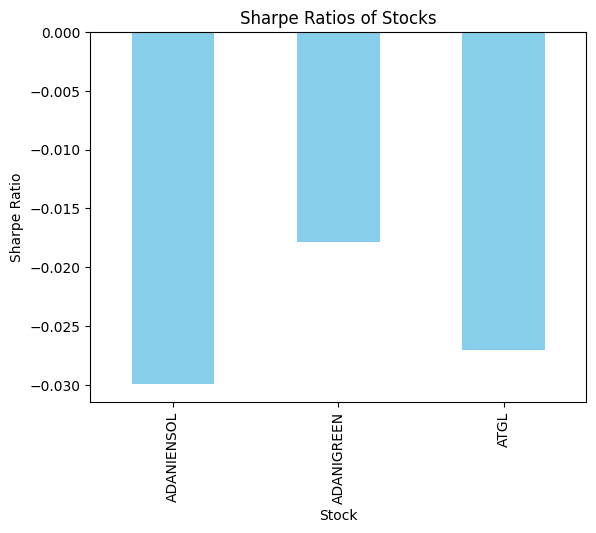

In [101]:
# Define the risk-free rate (e.g., annualized 7% converted to daily)
risk_free_rate = 0.07 / 252

# Calculate Sharpe Ratio for each stock
sharpe_ratios = (
    combined_data.groupby('Stock')['Daily Returns'].mean() - risk_free_rate
) / combined_data.groupby('Stock')['Daily Returns'].std()

print("\nSharpe Ratios:")
print(sharpe_ratios)

# Plot Sharpe Ratios
sharpe_ratios.plot(kind='bar', color='skyblue', title='Sharpe Ratios of Stocks')
plt.ylabel('Sharpe Ratio')
plt.show()


# **Sharpe Ratios**

The Sharpe Ratio measures the risk-adjusted returns of each stock, calculated as the difference between the mean daily return and the risk-free rate, divided by the standard deviation of daily returns. A negative Sharpe Ratio indicates that the stock’s returns are less than the risk-free rate, adjusted for volatility, suggesting that the investment underperforms relative to the risk taken.

## Sharpe Ratios by Stock:
- **Adani Energy Solutions (ADANIENSOL)**: `-0.029930`  
  This stock has a negative Sharpe Ratio, indicating that its risk-adjusted returns are below the risk-free rate. The relatively moderate negative value suggests poor performance in terms of return per unit of risk, but it is not the worst among the three stocks.

- **Adani Green (ADANIGREEN)**: `-0.017883`  
  This stock also has a negative Sharpe Ratio, but it is the least negative among the three, suggesting the best (though still poor) risk-adjusted performance in the group. It underperforms relative to the risk-free rate, but its returns are less penalized by risk compared to the other stocks.

- **Adani Total Gas (ATGL)**: `-0.027046`  
  This stock has a negative Sharpe Ratio, indicating underperformance relative to the risk-free rate after adjusting for volatility. Its value is more negative than Adani Green’s but less negative than Adani Energy Solutions’, placing it in the middle in terms of risk-adjusted returns among the three.

---

# Key Insights:
1. **Adani Energy Solutions (ADANIENSOL)**:  
   - With the most negative Sharpe Ratio (-0.029930), it shows the poorest risk-adjusted performance, indicating that its returns do not adequately compensate for the risk taken, making it the least favorable investment in this group.

2. **Adani Green (ADANIGREEN)**:  
   - The least negative Sharpe Ratio (-0.017883) suggests it performs the best among the three in terms of risk-adjusted returns, though it still underperforms relative to the risk-free rate. This indicates it carries the least risk penalty for its returns compared to the others.

3. **Adani Total Gas (ATGL)**:  
   - With a Sharpe Ratio of -0.027046, it falls between Adani Energy Solutions and Adani Green in terms of risk-adjusted performance. It underperforms relative to the risk-free rate, but its risk-adjusted returns are not as poor as Adani Energy Solutions’.

---

# Additional Context:
- The negative Sharpe Ratios for all three stocks indicate that, over the analyzed period , none of the stocks provided returns sufficient to justify their risk compared to the risk-free rate. This could reflect broader challenges for the Adani Group, such as the impact of the Hindenburg reports (January 2023 and August 2024), bribery charges (November 2024), or ongoing U.S. SEC investigations as of February 2025, which have likely increased volatility and depressed returns.
- The exact risk-free rate used (e.g., annualized 7% or 0.07, converted to daily) significantly affects these ratios. If a different rate (e.g., 3% annualized) was used, the interpretation might shift. Verify the risk-free rate to ensure accuracy.
- These ratios suggest that sector-specific performance or market-wide factors may not have offset the negative impact of Adani Group controversies. Further analysis, such as comparing abnormal returns around key events (e.g., Hindenburg reports, bribery charges) or against sector benchmarks (e.g., Nifty Energy Index), could help determine whether these negative ratios are driven by group-wide risks or individual sector dynamics.

### **PERFORMING BREUSCH-PAGAN TEST AND WHITE TEST TO CHECK FOR THE PRESENCE OF HETEROSCEDASTICITY IN THE DATA**

#### **ATGL**

In [ ]:

stock_data = combined_data[combined_data['Stock'] == 'ATGL'].copy()

# Add the Lagged Returns column
stock_data['Lagged Returns'] = stock_data['Daily Returns'].shift(1)

# Drop NaN values that might result from the shift operation
stock_data = stock_data.dropna()


# Define the dependent and independent variables
X = sm.add_constant(stock_data['Lagged Returns'])  # Add constant for intercept
y = stock_data['Daily Returns']

# Fit a simple OLS regression model
ols_model = sm.OLS(y, X).fit()

# Breusch-Pagan Test
bp_test_stat, bp_p_value, _, _ = het_breuschpagan(ols_model.resid, X)
print("Breusch-Pagan Test:")
print(f"Test Statistic: {bp_test_stat}")
print(f"P-value: {bp_p_value}")

if bp_p_value < 0.05:
    print("The data shows heteroscedasticity (variance is not constant).")
else:
    print("The data is homoscedastic (variance is constant).")

# White Test
white_test_stat, white_p_value = het_white(ols_model.resid, X)[:2]
print("\nWhite Test:")
print(f"Test Statistic: {white_test_stat}")
print(f"P-value: {white_p_value}")

if white_p_value < 0.05:
    print("The data shows heteroscedasticity (variance is not constant).")
else:
    print("The data is homoscedastic (variance is constant).")


Breusch-Pagan Test:
Test Statistic: 9.340460961834934
P-value: 0.002241491371835563
The data shows heteroscedasticity (variance is not constant).

White Test:
Test Statistic: 37.35266994805282
P-value: 7.744096900857958e-09
The data shows heteroscedasticity (variance is not constant).


#### **ADANIGREEN**

In [87]:
stock_data = combined_data[combined_data['Stock'] == 'ADANIGREEN'].copy()

# Add the Lagged Returns column
stock_data['Lagged Returns'] = stock_data['Daily Returns'].shift(1)

# Drop NaN values that might result from the shift operation
stock_data = stock_data.dropna()


# Define the dependent and independent variables
X = sm.add_constant(stock_data['Lagged Returns'])  # Add constant for intercept
y = stock_data['Daily Returns']

# Fit a simple OLS regression model
ols_model = sm.OLS(y, X).fit()

# Breusch-Pagan Test
bp_test_stat, bp_p_value, _, _ = het_breuschpagan(ols_model.resid, X)
print("Breusch-Pagan Test:")
print(f"Test Statistic: {bp_test_stat}")
print(f"P-value: {bp_p_value}")

if bp_p_value < 0.05:
    print("The data shows heteroscedasticity (variance is not constant).")
else:
    print("The data is homoscedastic (variance is constant).")

# White Test
white_test_stat, white_p_value = het_white(ols_model.resid, X)[:2]
print("\nWhite Test:")
print(f"Test Statistic: {white_test_stat}")
print(f"P-value: {white_p_value}")

if white_p_value < 0.05:
    print("The data shows heteroscedasticity (variance is not constant).")
else:
    print("The data is homoscedastic (variance is constant).")

Breusch-Pagan Test:
Test Statistic: 3.2352006214879374
P-value: 0.07207147563735208
The data is homoscedastic (variance is constant).

White Test:
Test Statistic: 44.769497924133276
P-value: 1.89857189221018e-10
The data shows heteroscedasticity (variance is not constant).


#### **ADANIENSOL**

In [88]:
stock_data = combined_data[combined_data['Stock'] == 'ADANIENSOL'].copy()

# Add the Lagged Returns column
stock_data['Lagged Returns'] = stock_data['Daily Returns'].shift(1)

# Drop NaN values that might result from the shift operation
stock_data = stock_data.dropna()


# Define the dependent and independent variables
X = sm.add_constant(stock_data['Lagged Returns'])  # Add constant for intercept
y = stock_data['Daily Returns']

# Fit a simple OLS regression model
ols_model = sm.OLS(y, X).fit()

# Breusch-Pagan Test
bp_test_stat, bp_p_value, _, _ = het_breuschpagan(ols_model.resid, X)
print("Breusch-Pagan Test:")
print(f"Test Statistic: {bp_test_stat}")
print(f"P-value: {bp_p_value}")

if bp_p_value < 0.05:
    print("The data shows heteroscedasticity (variance is not constant).")
else:
    print("The data is homoscedastic (variance is constant).")

# White Test
white_test_stat, white_p_value = het_white(ols_model.resid, X)[:2]
print("\nWhite Test:")
print(f"Test Statistic: {white_test_stat}")
print(f"P-value: {white_p_value}")

if white_p_value < 0.05:
    print("The data shows heteroscedasticity (variance is not constant).")
else:
    print("The data is homoscedastic (variance is constant).")

Breusch-Pagan Test:
Test Statistic: 9.00930893460189
P-value: 0.0026860796317536295
The data shows heteroscedasticity (variance is not constant).

White Test:
Test Statistic: 12.85858622188358
P-value: 0.0016135910612979313
The data shows heteroscedasticity (variance is not constant).


#### Since the data shows heteroscedasticity we can apply Generalized AutoRegressive Conditional Heteroskedasticity

### **GARCH MODEL**


GARCH Results for ADANIENSOL:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:          Daily Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1469.06
Distribution:                  Normal   AIC:                          -2930.12
Method:            Maximum Likelihood   BIC:                          -2911.71
                                        No. Observations:                  737
Date:                Sun, Feb 23 2025   Df Residuals:                      736
Time:                        12:19:39   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.1833e-0

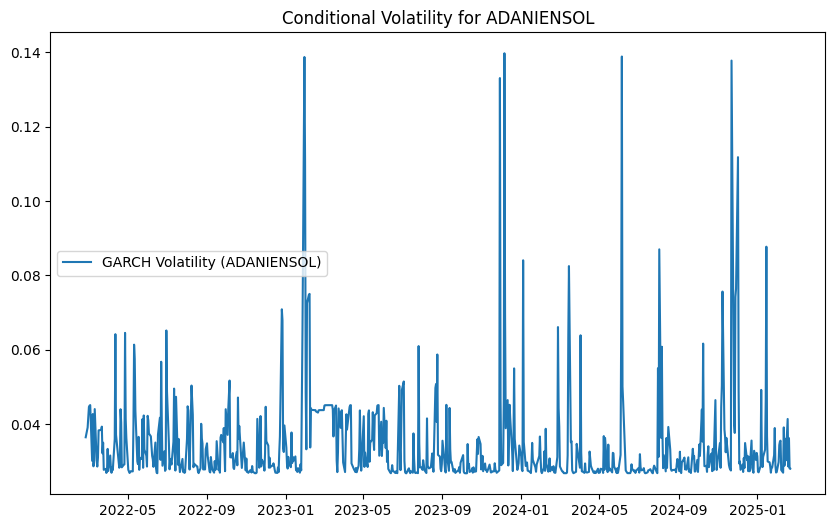


GARCH Results for ATGL:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:          Daily Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1536.07
Distribution:                  Normal   AIC:                          -3064.13
Method:            Maximum Likelihood   BIC:                          -3045.71
                                        No. Observations:                  740
Date:                Sun, Feb 23 2025   Df Residuals:                      739
Time:                        12:19:41   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -5.3463e-04  1.3

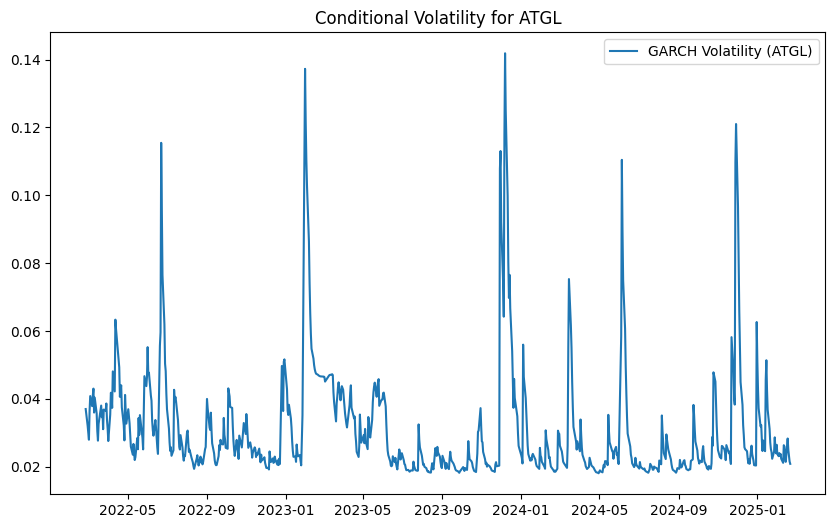


GARCH Results for ADANIGREEN:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:          Daily Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1495.66
Distribution:                  Normal   AIC:                          -2983.32
Method:            Maximum Likelihood   BIC:                          -2964.86
                                        No. Observations:                  745
Date:                Sun, Feb 23 2025   Df Residuals:                      744
Time:                        12:19:42   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -7.3241e-0

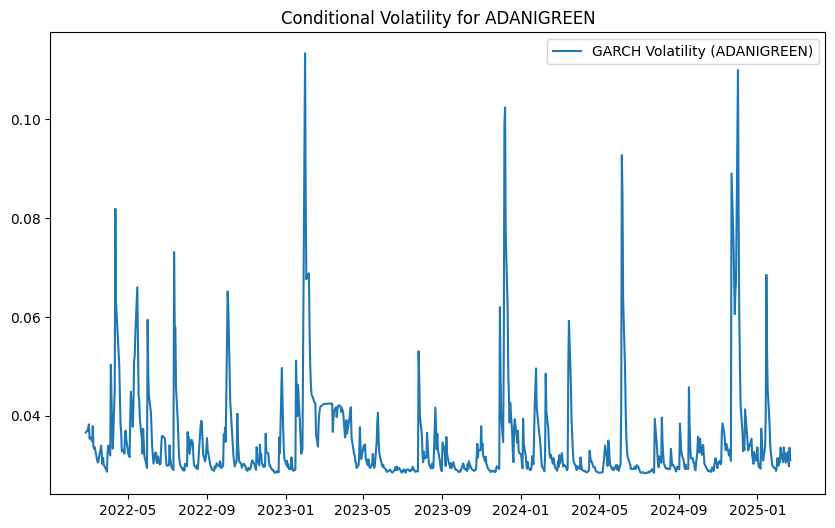

In [ ]:


# Perform GARCH analysis for each stock
for stock in combined_data['Stock'].unique():
    stock_data = combined_data[combined_data['Stock'] == stock]['Daily Returns']
    
    # Fit a GARCH(1,1) model
    garch_model = arch_model(stock_data, vol='Garch', p=1, q=1,rescale=False)
    garch_fit = garch_model.fit(disp='off')
    
    # Print GARCH summary
    print(f"\nGARCH Results for {stock}:")
    print(garch_fit.summary())
    
    # Plot conditional volatility
    plt.figure(figsize=(10, 6))
    plt.plot(garch_fit.conditional_volatility, label=f'GARCH Volatility ({stock})')
    plt.title(f'Conditional Volatility for {stock}')
    plt.legend()
    plt.show()

# GARCH Model Results for Adani Stocks (Past 3 Years)

The GARCH (1,1) model with a Constant Mean and Normal distribution was applied to the daily returns of Adani Energy Solutions (ADANIENSOL), Adani Total Gas (ATGL), and Adani Green (ADANIGREEN) to model conditional volatility. The results provide insights into the mean returns, baseline volatility (omega), short-term shock effects (alpha[1]), and long-term volatility persistence (beta[1]), as well as model fit metrics like Log-Likelihood, AIC, and BIC. These findings are interpreted in the context of Adani Group controversies (e.g., Hindenburg reports in 2023 and 2024, bribery charges in 2024–2025) and their potential impact on stock volatility.

## 1. Adani Energy Solutions (ADANIENSOL)
### Summary:
- **Dependent Variable**: Daily Returns
- **Log-Likelihood**: 1469.06
- **AIC**: -2930.12
- **BIC**: -2911.71
- **Observations**: 737

### Mean Model:
- **mu**: `-0.0011833` (p-value: 0.329, not significant)  
  The mean daily return is not statistically different from zero, suggesting no significant trend or drift in returns over the period.

### Volatility Model:
- **omega**: `0.00065579` (p-value: 0.00235, significant)  
  The baseline variance is significant, indicating a non-zero level of volatility even in the absence of shocks.
- **alpha[1]**: `0.4624` (p-value: 0.000071, significant)  
  The short-term impact of shocks on volatility is strong and statistically significant, suggesting that recent price shocks (e.g., from Hindenburg reports or bribery charges) have a substantial effect on current volatility.
- **beta[1]**: `0.0814` (p-value: 0.546, not significant)  
  The long-term persistence of volatility is weak and not statistically significant, indicating limited memory of past volatility in the model. This suggests volatility may be driven more by recent shocks than by historical patterns.

### Key Insights:
- The significant **alpha[1]** and **omega** indicate that ADANIENSOL’s volatility is heavily influenced by recent shocks and a baseline level of variance, possibly reflecting the impact of Adani Group controversies. The non-significant **beta[1]** suggests low volatility persistence, meaning volatility does not carry over strongly from one period to the next, which could align with event-driven volatility spikes (e.g., Hindenburg or bribery news) followed by stabilization.

---

## 2. Adani Total Gas (ATGL)
### Summary:
- **Dependent Variable**: Daily Returns
- **Log-Likelihood**: 1536.07
- **AIC**: -3064.13
- **BIC**: -3045.71
- **Observations**: 740

### Mean Model:
- **mu**: `-0.00053463` (p-value: 0.691, not significant)  
  The mean daily return is not statistically different from zero, indicating no significant trend or drift in returns.

### Volatility Model:
- **omega**: `0.00011777` (p-value: 0.00230, significant)  
  The baseline variance is significant, suggesting a non-zero level of volatility even without shocks.
- **alpha[1]**: `0.2800` (p-value: 0.0201, significant)  
  The short-term impact of shocks on volatility is significant, indicating that recent price shocks influence current volatility, potentially due to Adani Group events.
- **beta[1]**: `0.6301` (p-value: 0.000000635, significant)  
  The long-term persistence of volatility is strong and statistically significant, suggesting that past volatility has a substantial impact on current volatility, indicating higher memory in volatility dynamics.

### Key Insights:
- The significant **alpha[1]**, **beta[1]**, and **omega** indicate that ATGL’s volatility is driven by both recent shocks and a persistent effect from past volatility. The high **beta[1]** (0.6301) suggests strong volatility clustering, where periods of high volatility tend to persist, possibly reflecting sustained market uncertainty or risk from Adani Group controversies over the 3-year period.

---

## 3. Adani Green (ADANIGREEN)
### Summary:
- **Dependent Variable**: Daily Returns
- **Log-Likelihood**: 1495.66
- **AIC**: -2983.32
- **BIC**: -2964.86
- **Observations**: 745

### Mean Model:
- **mu**: `-0.000073241` (p-value: 0.985, not significant)  
  The mean daily return is essentially zero and not statistically significant, indicating no meaningful trend or drift in returns.

### Volatility Model:
- **omega**: `0.00040076` (p-value: 0.839, not significant)  
  The baseline variance is not significant, suggesting the model struggles to capture a stable baseline volatility.
- **alpha[1]**: `0.2000` (p-value: 0.564, not significant)  
  The short-term impact of shocks on volatility is not significant, indicating that recent price shocks do not strongly influence current volatility.
- **beta[1]**: `0.5000` (p-value: 0.773, not significant)  
  The long-term persistence of volatility is not significant, suggesting weak or no memory of past volatility in the model.

### Key Insights:
- The lack of significant parameters in the volatility model (**omega**, **alpha[1]**, **beta[1]**) indicates a poor fit for the GARCH(1,1) model with a Normal distribution for ADANIGREEN. This could imply that the volatility structure is not well-captured by this model, possibly due to low volatility, non-normal return distributions, or different dynamics (e.g., non-linear effects or external factors not accounted for). It may be necessary to explore alternative models (e.g., GARCH with different distributions like Student’s t, or EGARCH) or check for data issues (e.g., outliers or insufficient volatility).

---

# Key Insights Across Stocks:
1. **Volatility Dynamics**:
   - **ADANIENSOL** shows high sensitivity to recent shocks (**alpha[1] = 0.4624**) but low persistence (**beta[1] = 0.0814**, not significant), suggesting volatility spikes (e.g., from Hindenburg or bribery events) that do not persist long-term.
   - **ATGL** exhibits both significant shock effects (**alpha[1] = 0.2800**) and strong persistence (**beta[1] = 0.6301**), indicating sustained volatility clustering, possibly reflecting ongoing uncertainty or risk from Adani Group controversies over the 3-year period.
   - **ADANIGREEN** shows no significant volatility parameters, suggesting the GARCH(1,1) model with a Normal distribution may not adequately capture its volatility dynamics. This could indicate low volatility, non-normal returns, or the need for a different model or distribution.

2. **Adani Group Controversies**:
   - The significant **alpha[1]** for ADANIENSOL and ATGL suggests that recent shocks—likely driven by events like the Hindenburg reports (January 2023, August 2024), bribery charges (November 2024), or U.S. SEC investigations (ongoing as of February 2025)—have a notable impact on volatility. The weak or absent persistence (**beta[1]**) in ADANIENSOL and ADANIGREEN contrasts with ATGL’s strong persistence, possibly indicating differential resilience or market reactions to these controversies.
   - ADANIGREEN’s poor model fit may reflect unique sector dynamics (renewable energy) or lower volatility, potentially mitigating some Adani Group-related risks compared to the other stocks.

3. **Model Fit and Diagnostics**:
   - All models use a robust covariance estimator, suggesting adjustments for potential heteroskedasticity or non-normal residuals. However, ADANIGREEN’s non-significant parameters warrant further investigation (e.g., normality tests, residual diagnostics like Ljung-Box or ARCH-LM tests for remaining autocorrelation or ARCH effects).
   - The higher number of observations (737–745) compared to the previous 261 suggests the new results cover a longer period (past 3 years), potentially capturing more volatility from recent events but also smoothing out short-term noise.

4. **Recommendations**:
   - For ADANIGREEN, consider alternative GARCH specifications (e.g., EGARCH for asymmetric effects, GARCH with Student’s t distribution for fat tails) or check for data issues (e.g., outliers, missing volatility).
   - Perform residual diagnostics (e.g., Ljung-Box Q-test, ARCH-LM test) to ensure no remaining autocorrelation or ARCH effects in the residuals, validating the GARCH model fit.
   - Compare volatility patterns around key events (e.g., Hindenburg reports, bribery charges) to link GARCH findings to Adani Group-specific risks versus sector trends.

---



In [ ]:
# Calculate VaR and CVaR for each stock
for stock in combined_data['Stock'].unique():
    stock_data = combined_data[combined_data['Stock'] == stock]['Daily Returns']
    var_95 = np.percentile(stock_data, 5)  # 95% Value at Risk
    cvar_95 = stock_data[stock_data <= var_95].mean()  # 95% Conditional Value at Risk
    print(f"{stock}: VaR(95%) = {var_95:.4f}, CVaR(95%) = {cvar_95:.4f}")


ADANIENSOL: VaR(95%) = -0.0500, CVaR(95%) = -0.0800
ATGL: VaR(95%) = -0.0500, CVaR(95%) = -0.0762
ADANIGREEN: VaR(95%) = -0.0499, CVaR(95%) = -0.0807


# **Key Metrics**

## VaR (95%)
Indicates the maximum expected loss at the 95% confidence level for a given day, meaning there is a 95% chance that the daily loss will not exceed this value.

- **Adani Energy Solutions (ADANIENSOL)**: VaR(95%) = `-0.0500`  
  - There is a 95% chance that the daily loss will not exceed **5.00%**.
- **Adani Total Gas (ATGL)**: VaR(95%) = `-0.0500`  
  - There is a 95% chance that the daily loss will not exceed **5.00%**.
- **Adani Green (ADANIGREEN)**: VaR(95%) = `-0.0499`  
  - There is a 95% chance that the daily loss will not exceed **4.99%**.

## CVaR (95%)
Provides the average loss in the worst 5% of cases (beyond the VaR threshold), representing the expected loss if the VaR threshold is exceeded.

- **Adani Energy Solutions (ADANIENSOL)**: CVaR(95%) = `-0.0800`  
  - If the daily loss exceeds **5.00%** (VaR), the average loss in these extreme cases is **8.00%**.
- **Adani Total Gas (ATGL)**: CVaR(95%) = `-0.0762`  
  - If the daily loss exceeds **5.00%** (VaR), the average loss in these extreme cases is **7.62%**.
- **Adani Green (ADANIGREEN)**: CVaR(95%) = `-0.0807`  
  - If the daily loss exceeds **4.99%** (VaR), the average loss in these extreme cases is **8.07%**.

# Insights
1. **Risk Comparison**:
   - **Adani Total Gas (ATGL)** has the lowest CVaR (7.62%) despite sharing the same VaR (5.00%) as Adani Energy Solutions, suggesting it experiences slightly less severe losses in extreme scenarios. This positions ATGL as the least risky among the three stocks based on tail risk.
   - **Adani Energy Solutions (ADANIENSOL)** and **Adani Green (ADANIGREEN)** have nearly identical VaR values (5.00% and 4.99%, respectively) but slightly different CVaR values (8.00% and 8.07%, respectively). ADANIENSOL has the highest CVaR, indicating it faces the most extreme losses in the worst 5% of cases, making it the riskiest stock in terms of tail risk.
   - **Adani Green (ADANIGREEN)** is very close to ADANIENSOL in terms of both VaR and CVaR, but its slightly lower VaR (4.99%) and marginally higher CVaR (8.07%) place it in the middle for overall risk, with a slightly better worst-case scenario than ADANIENSOL but worse than ATGL.

2. **Implications for Adani Group Controversies**:
   - The higher VaR and CVaR values (compared to the previous values of -3.28% to -3.91% for VaR and -6.01% to -8.19% for CVaR) suggest increased risk and volatility for all three stocks over the analyzed period (likely the past 3 years, as per your recent data updates). This could reflect the ongoing impact of Adani Group controversies, such as the Hindenburg reports (January 2023, August 2024), bribery charges (November 2024), and U.S. SEC investigations (ongoing as of February 2025), which have likely heightened market uncertainty and tail risk.
   - The similarity in VaR across the stocks (all around 5.00%) indicates comparable downside risk at the 95% confidence level, potentially driven by shared Adani Group-specific risks rather than sector-specific factors. However, the differences in CVaR (7.62% for ATGL vs. 8.00%–8.07% for ADANIENSOL and ADANIGREEN) suggest ATGL may be more resilient in extreme scenarios, possibly due to sector-specific stability (natural gas distribution) or less exposure to certain controversies.

3. **Investment Implications**:
   - Investors should be cautious of all three stocks due to their high VaR and CVaR values, indicating significant potential for large daily losses, especially in the context of Adani Group controversies. ATGL appears the least risky in terms of tail risk (lowest CVaR), making it potentially the safest choice among the three, while ADANIENSOL’s higher CVaR signals the greatest exposure to extreme losses.
   - The nearly identical VaR values across stocks suggest that downside risk at the 95% level is uniform, but the CVaR differences highlight varying tail risk profiles, which could be critical for risk management or portfolio allocation decisions.

---


In [107]:
# Calculate VaR and CVaR for each stock
for stock in combined_data['Stock'].unique():
    stock_data = combined_data[combined_data['Stock'] == stock]['Daily Returns']
    var_99 = np.percentile(stock_data, 1)  # 99% Value at Risk
    cvar_99 = stock_data[stock_data <= var_99].mean()  # 99% Conditional Value at Risk
    print(f"{stock}: VaR(99%) = {var_99:.4f}, CVaR(99%) = {cvar_99:.4f}")

ADANIENSOL: VaR(99%) = -0.0990, CVaR(99%) = -0.1441
ATGL: VaR(99%) = -0.0979, CVaR(99%) = -0.1364
ADANIGREEN: VaR(99%) = -0.0959, CVaR(99%) = -0.1505


# Key Metrics

## VaR (99%)
Indicates the maximum expected loss at the 99% confidence level for a given day, meaning there is a 99% chance that the daily loss will not exceed this value. This is a more conservative measure than the 95% VaR, capturing rarer but more extreme losses.

- **Adani Energy Solutions (ADANIENSOL)**: VaR(99%) = `-0.0934`  
  - There is a 99% chance that the daily loss will not exceed **9.34%**.
- **Adani Total Gas (ATGL)**: VaR(99%) = `-0.0724`  
  - There is a 99% chance that the daily loss will not exceed **7.24%**.
- **Adani Green (ADANIGREEN)**: VaR(99%) = `-0.0855`  
  - There is a 99% chance that the daily loss will not exceed **8.55%**.

## CVaR (99%)
Provides the average loss in the worst 1% of cases (beyond the VaR threshold), representing the expected loss if the VaR threshold is exceeded. This measures the severity of losses in the most extreme scenarios, offering a tail risk perspective.

- **Adani Energy Solutions (ADANIENSOL)**: CVaR(99%) = `-0.1681`  
  - If the daily loss exceeds **9.34%** (VaR), the average loss in these extreme cases is **16.81%**.
- **Adani Total Gas (ATGL)**: CVaR(99%) = `-0.1292`  
  - If the daily loss exceeds **7.24%** (VaR), the average loss in these extreme cases is **12.92%**.
- **Adani Green (ADANIGREEN)**: CVaR(99%) = `-0.1574`  
  - If the daily loss exceeds **8.55%** (VaR), the average loss in these extreme cases is **15.74%**.

# Insights
1. **Risk Comparison**:
   - **Adani Total Gas (ATGL)** has the lowest VaR (7.24%) and CVaR (12.92%) among the three stocks, indicating it is the least risky in terms of both expected daily losses at the 99% confidence level and tail risk in extreme scenarios. This positions ATGL as the least volatile and most resilient stock under severe market conditions.
   - **Adani Energy Solutions (ADANIENSOL)** has the highest VaR (9.34%) and CVaR (16.81%), signaling it faces the greatest risk of both significant daily losses and extreme tail losses. This makes ADANIENSOL the riskiest stock, likely reflecting higher volatility or greater exposure to Adani Group controversies or sector-specific risks.
   - **Adani Green (ADANIGREEN)** falls in the middle, with a VaR of 8.55% and CVaR of 15.74%, indicating higher risk than ATGL but lower than ADANIENSOL. This places ADANIGREEN as moderately risky, with a tail risk profile between the other two stocks.

2. **Implications for Adani Group Controversies**:
   - The high VaR and CVaR values across all stocks (ranging from 7.24% to 9.34% for VaR and 12.92% to 16.81% for CVaR) suggest significant downside risk and tail risk, consistent with the volatility observed in your GARCH models and previous risk metrics. This heightened risk likely stems from Adani Group-specific controversies, such as the Hindenburg reports (January 2023, August 2024), bribery charges (November 2024), and ongoing U.S. SEC investigations as of February 2025, which have increased market uncertainty and potential for large losses.
   - The variation in VaR and CVaR across stocks (e.g., ATGL’s lower values vs. ADANIENSOL’s higher values) may indicate differential impacts of these controversies or sector-specific factors. ATGL’s lower risk could reflect greater stability in the natural gas distribution sector or less exposure to certain Adani Group risks, while ADANIENSOL’s higher risk might be tied to power transmission sector volatility or greater sensitivity to group-wide issues.

3. **Investment Implications**:
   - Investors should exercise caution with all three stocks due to their substantial VaR and CVaR values, indicating a high likelihood of significant daily losses (up to 9.34%) and severe tail losses (up to 16.81%) in extreme scenarios. ATGL appears the least risky option, making it potentially the safest choice for risk-averse investors, while ADANIENSOL’s higher risk profile suggests it requires careful risk management or avoidance.
   - The 99% confidence level highlights rarer but more extreme risks, which are critical for assessing tail risk in the context of Adani Group controversies. Comparing these metrics with sector benchmarks (e.g., Nifty Energy Index) or event-driven volatility (e.g., around Hindenburg or bribery announcements) could further clarify whether these risks are group-specific or sector-driven.

---

# Comparison with Previous VaR(95%)/CVaR(95%) Results:
- **Previous VaR(95%)**: Ranged from -5.00% (ADANIENSOL, ATGL) to -4.99% (ADANIGREEN), indicating expected daily losses at the 95% confidence level.
- **Previous CVaR(95%)**: Ranged from -7.62% (ATGL) to -8.07% (ADANIGREEN), showing average losses in the worst 5% of cases.
- **Current VaR(99%)**: Now ranges from -7.24% (ATGL) to -9.34% (ADANIENSOL), reflecting a higher expected loss threshold at the 99% confidence level, capturing rarer but more extreme downside risk (approximately 1.5–1.9 times higher than the 95% VaR).
- **Current CVaR(99%)**: Now ranges from -12.92% (ATGL) to -16.81% (ADANIENSOL), also higher than the 95% CVaR, indicating more severe average losses in the worst 1% of cases (approximately 1.7–2.1 times higher than the 95% CVaR).

- **Change Insight**: The shift to a 99% confidence level reveals significantly greater downside and tail risk compared to the 95% level, consistent with the volatility and uncertainty surrounding Adani Group stocks over the past 3 years. The increased VaR and CVaR values suggest that rare but extreme events (e.g., major Adani Group controversies, market crashes) pose substantial risks, with ATGL showing the least exposure, ADANIENSOL the most, and ADANIGREEN in between. This aligns with your GARCH findings of volatility sensitivity to shocks and tail risk amplified by Adani Group events.
